In [1]:
from autolens.imaging import image as im
from autolens.imaging import mask as ma
from autolens.lensing import fitting
from autolens.lensing import ray_tracing
from autolens.lensing import galaxy as g
from autolens.lensing import lensing_image as li
from autolens.profiles import light_profiles as lp
from autolens.profiles import mass_profiles as mp
from autolens.plotting import imaging_plotters
from autolens.plotting import ray_tracing_plotters
from autolens.plotting import fitting_plotters

# In this example, we'll fit the image we simulated in the previous exercise. We'll do this using model images generated
# via a tracer, and by compairing to the simulated image we'll get diagostics about the quality of the fit.

In [2]:
# First, we load the image-data we simualted in the previous tutorial.
path = 'path/to/AutoLens/howtolens/0_introduction' # Unfortunately, in a Jupyter notebook you have to manually specify the path to PyAutoLens and this tutorial.
path = '/home/jammy/PyCharm/Projects/AutoLens/howtolens/0_introduction'
image = im.load_imaging_from_path(image_path=path + '/data/image.fits',
                                  noise_map_path=path+'/data/noise_map.fits',
                                  psf_path=path + '/data/psf.fits', pixel_scale=0.05)

In [4]:
# To fit an image, we first specify a mask. A mask describes the sections of the image that we fit. 

# Typically, we want to mask out regions of the image where the lens and source galaxies are not visible, for example
# at the edges where the signal is entirely background sky and noise.

# For the image we simulated, a 3" circular mask will do the job. 

mask = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=3.0)
print(mask)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


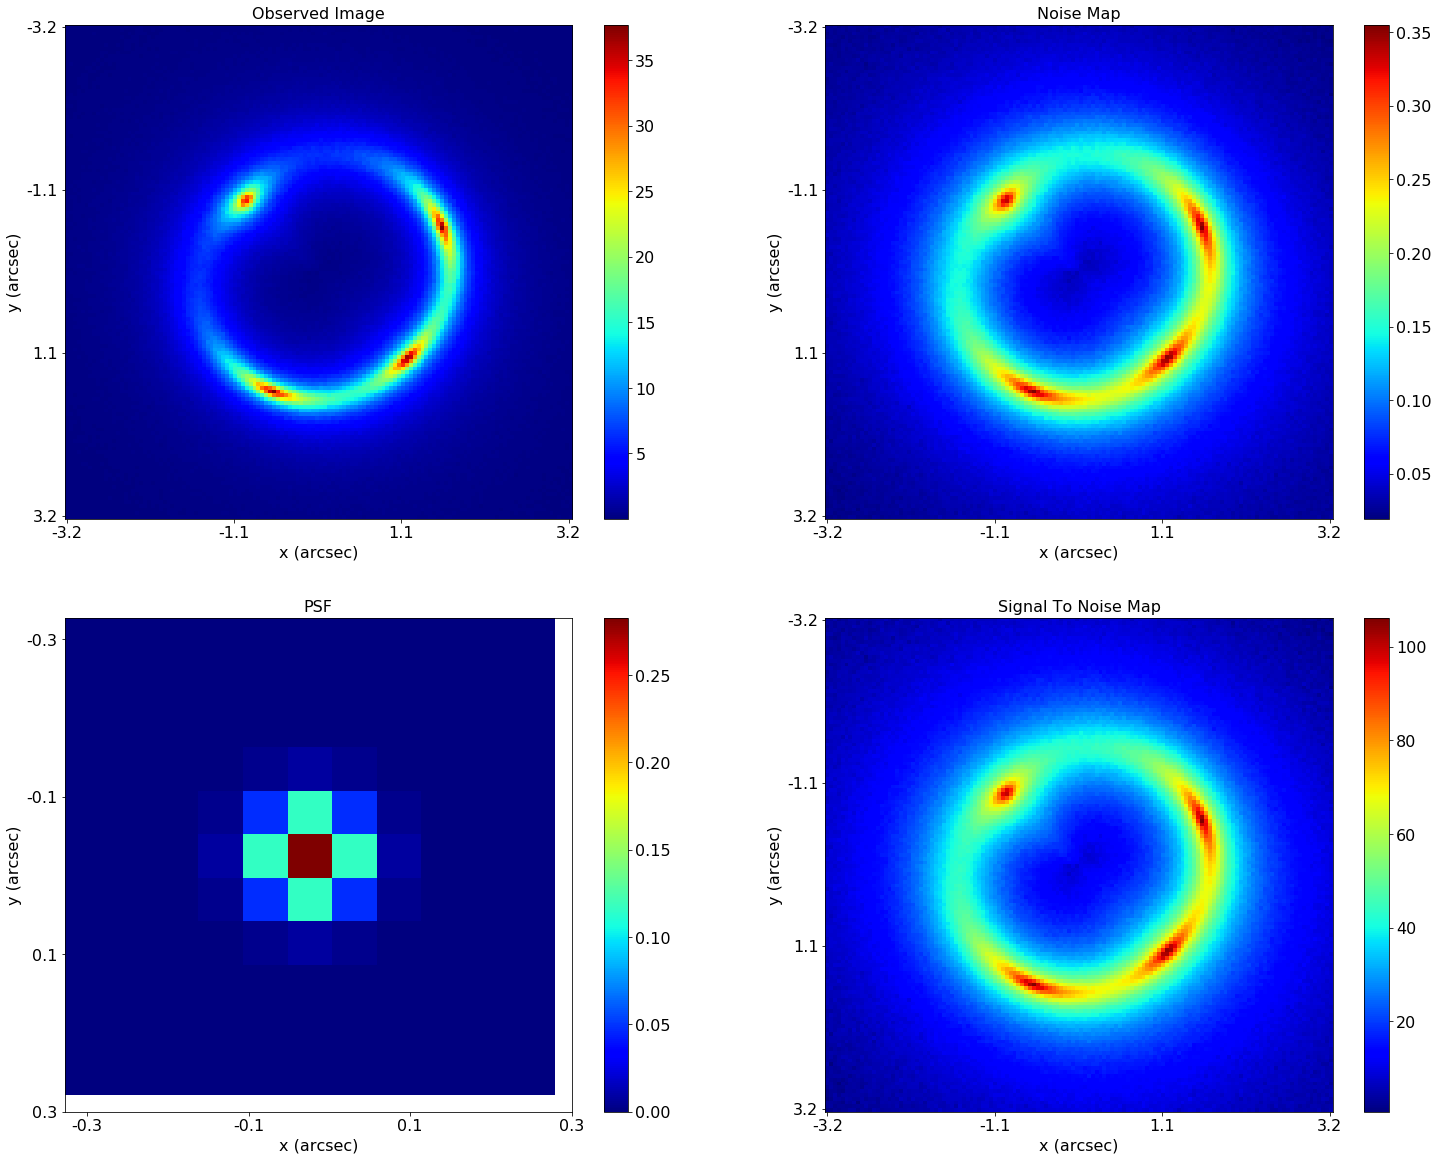

In [5]:
# Now we've loaded the image and created a mask, we use them to create a 'lensing image', which we'll perform using the
# lensing_module (imported as 'li').

# A lensing image is a 'package' of all parts of the the image data we need in order to fit it:

# 1) The image.

# 2) The PSF: so that when we compare a tracer's image-plane image to the image data we can include blurring due to 
#    the telescope optics.

# 3) The noise-map: so our goodness-of-fit measure accounts for noise in the observations.

# 4) The image's grids: so the tracer's image-plane image is generated on the same (masked) grid as the image-data.

lensing_image = li.LensingImage(image=image, mask=mask)
imaging_plotters.plot_image(lensing_image.image)

In [6]:
# By printing its attribute, we can see that it does indeed contain the image, mask, psf and so on
print('Image:')
print(lensing_image.image)
print('Noise-Map:')
print(lensing_image.image.noise_map)
print('PSF:')
print(lensing_image.image.psf)
print('Mask')
print(lensing_image.mask)
print('Grid')
print(lensing_image.grids.image)

Image:
[[0.08870192 0.06738194 0.13621603 ... 0.10178166 0.06395902 0.01296077]
 [0.10071528 0.11632052 0.07209171 ... 0.0667845  0.04205517 0.06416203]
 [0.04288269 0.11209171 0.06481275 ... 0.05532676 0.08034379 0.06887637]
 ...
 [0.075115   0.08345117 0.07532676 ... 0.14936698 0.08768994 0.0896089 ]
 [0.06395902 0.09538851 0.04367712 ... 0.11768994 0.12642799 0.13874209]
 [0.0262941  0.03749536 0.06887637 ... 0.0896089  0.10874209 0.16143276]]
Noise-Map:
[[0.02508    0.02362075 0.02806041 ... 0.02593464 0.02337798 0.01940453]
 [0.02586602 0.02685272 0.02395076 ... 0.02357856 0.02176045 0.02339245]
 [0.02182374 0.02658895 0.02343877 ... 0.02275425 0.02451828 0.02372596]
 ...
 [0.02416023 0.0247286  0.02417483 ... 0.02883094 0.02501266 0.0251402 ]
 [0.02337798 0.02552048 0.02188433 ... 0.02693758 0.0274729  0.02821005]
 [0.02051781 0.02140836 0.02372596 ... 0.0251402  0.02637815 0.02952021]]
PSF:
[[1.41154415e-20 4.20775380e-17 2.11995722e-14 1.80519780e-12
  2.59802552e-11 6.31950341

In [8]:
# The shapes of these grids reveals they are 1D and have been masked:
print(lensing_image.image.shape) # This is the original 2D image
print(lensing_image.shape)
print(lensing_image.noise_map.shape)
print(lensing_image.grids.image.shape)

(130, 130)
(11304,)
(11304,)
(11304, 2)


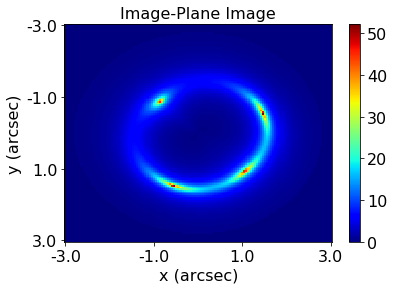

In [9]:
# To fit an image, we need to create an image-plane image using a tracer.
# Lets use the same tracer we simulated the image with (thus, our fit should be 'perfect').

# Its worth noting that below, we use the lensing_image's grids to setup the tracer. This ensures that our image-plane
# image will be the same resolution and alignment as our image-data, as well as being masked appropriately.

lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
ray_tracing_plotters.plot_ray_tracing_individual(tracer=tracer, plot_image_plane_image=True)

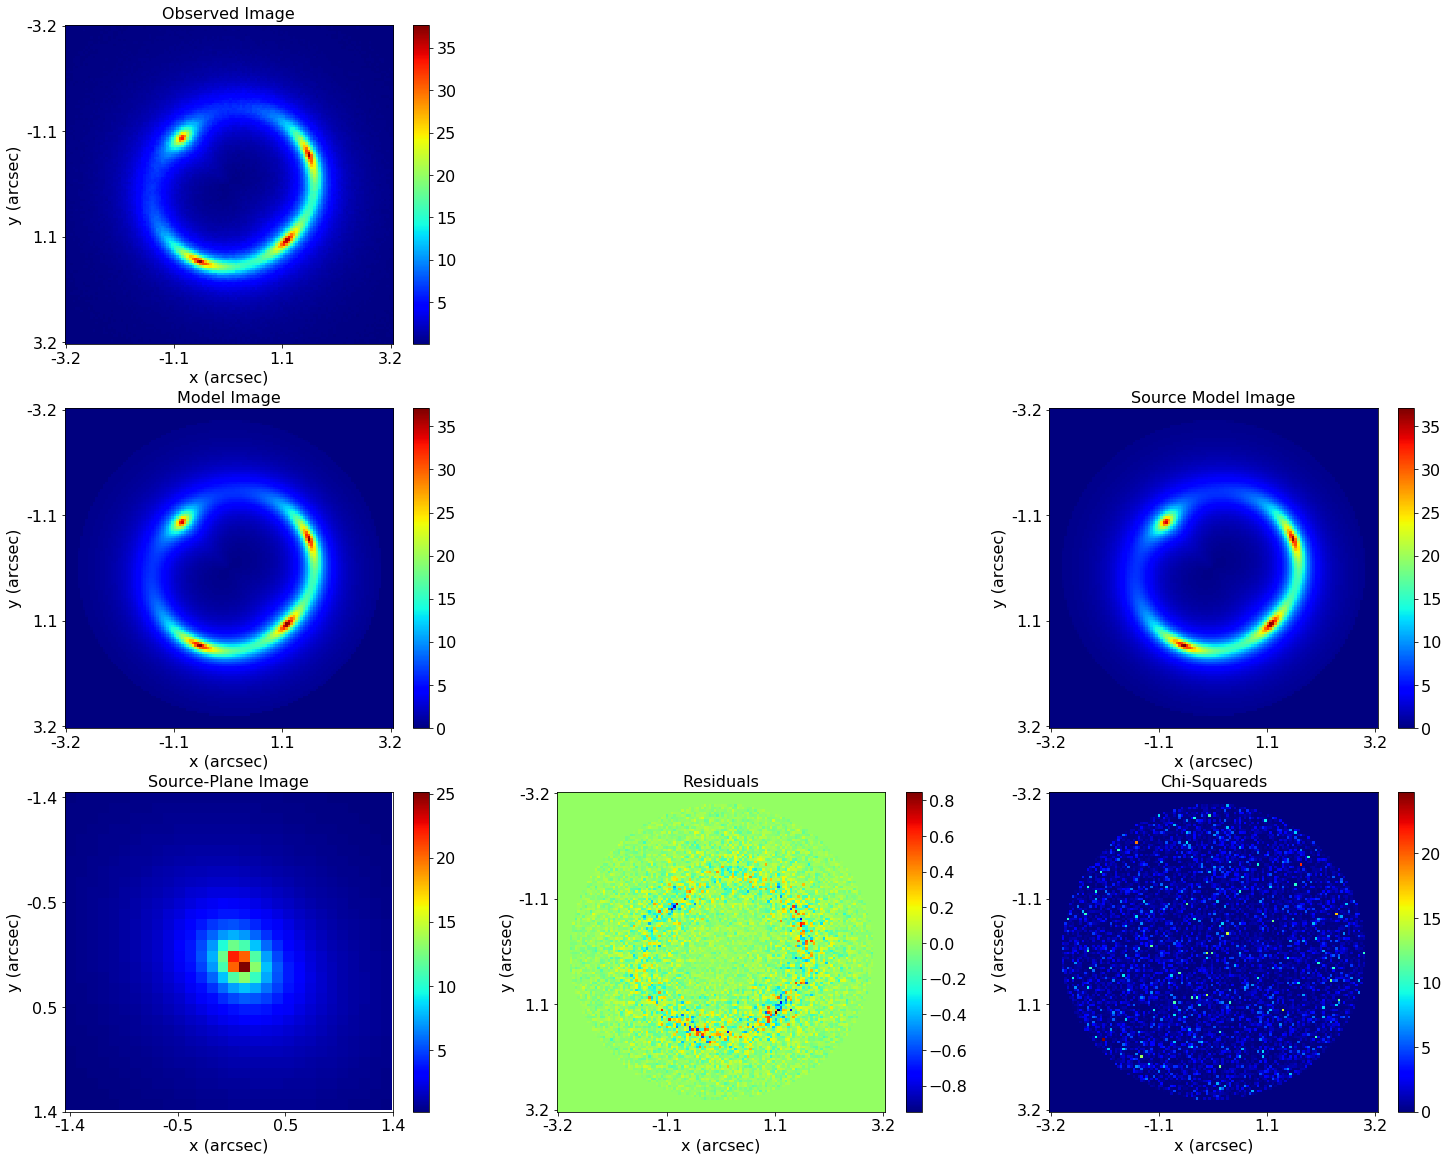

In [11]:
# To fit the image, we pass the lensing image and tracer to the fitting module. This performs the following:

# 1) Blurs the tracer's image-plane image with the lensing-image's PSF, ensuring that the telescope optics are 
#    accounted for by the fit. This creates the fit's 'model_image'.

# 2) Computes the difference between this model_image and the observed image-data, creating the fit's 'residuals'.

# 3) Divides the residuals by the noise-map and squaring each value, creating the fits 'chi-squareds'. 

# 4) Sums up these chi-squared values and converts them to a 'likelihood', which quantities how good the tracer's fit 
#    to the data was (higher likelihood = better fit).

fit = fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting(fit=fit)

In [13]:
# We can print the fit's attributes:
print('Model-Image:')
print(fit.model_image)
print('Residuals:')
print(fit.residuals)
print('Chi-Squareds:')
print(fit.chi_squareds)

Model-Image:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Residuals:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Chi-Squareds:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Likelihood:
11821.162247934872


In [ ]:
# It also provides a likelihood, which is a single-figure estimate of how good the model image fitted the
# simulated image.
print('Likelihood:')
print(fit.likelihood)

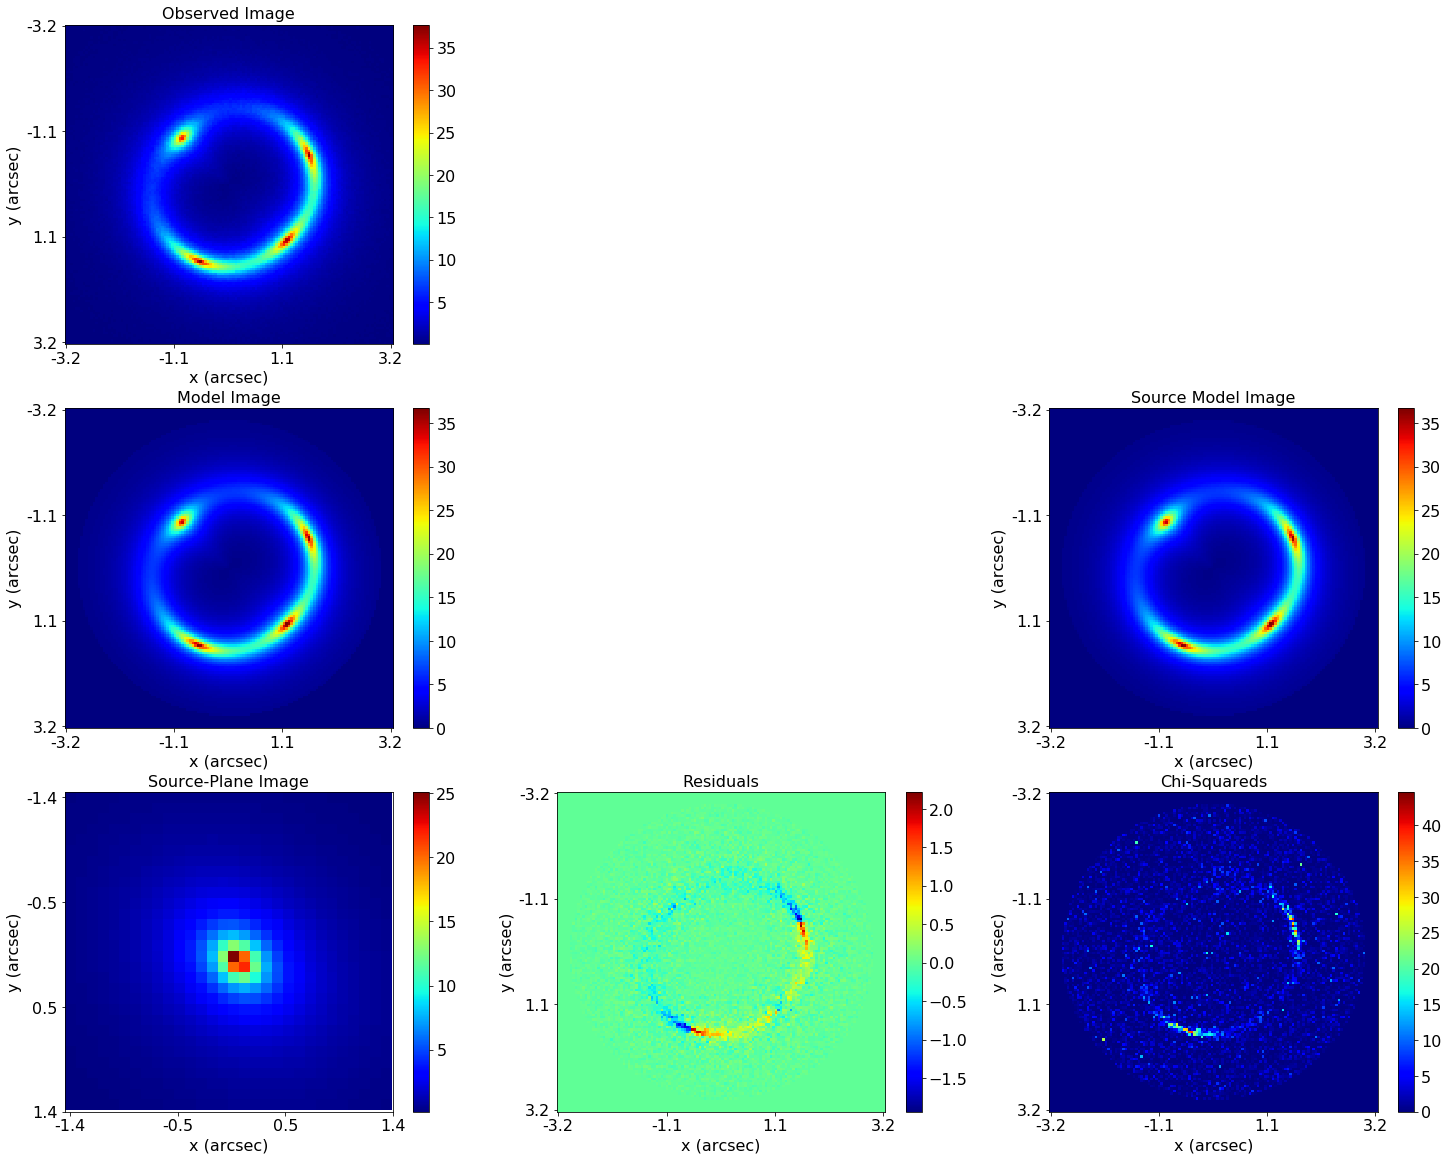

In [15]:
# We used the same tracer to create and fit the image. Therefore, our fit to the image was excellent.
# For example, by inspecting the residuals and chi-squareds, one can see no signs of the source galaxy's light present
# and we only see the noise that we simulated the image with.

# This solution should translate to one of the highest-likelihood solutions possible.

# Lets change the tracer, so that it's near the correct solution, but slightly off. 
# All we're going to do is slightly offset the lens galaxy, by 0.005"

lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.005, 0.005), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
fit = fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting(fit=fit)

In [18]:
# We now observe residuals to appear at the locations the source galaxy was observed, which 
# corresponds to an increase in our chi-squareds (which determines our goodness-of-fit).

# Lets compare the likelihood to the value we computed above (which was 11697.24):
print('Previous Likelihood:')
print(11697.24)
print('New Likelihood:')
print(fit.likelihood)
# It decreases! This model was a worse fit to the data.

Previous Likelihood:
11697.24
Likelihood:
10319.44023076275


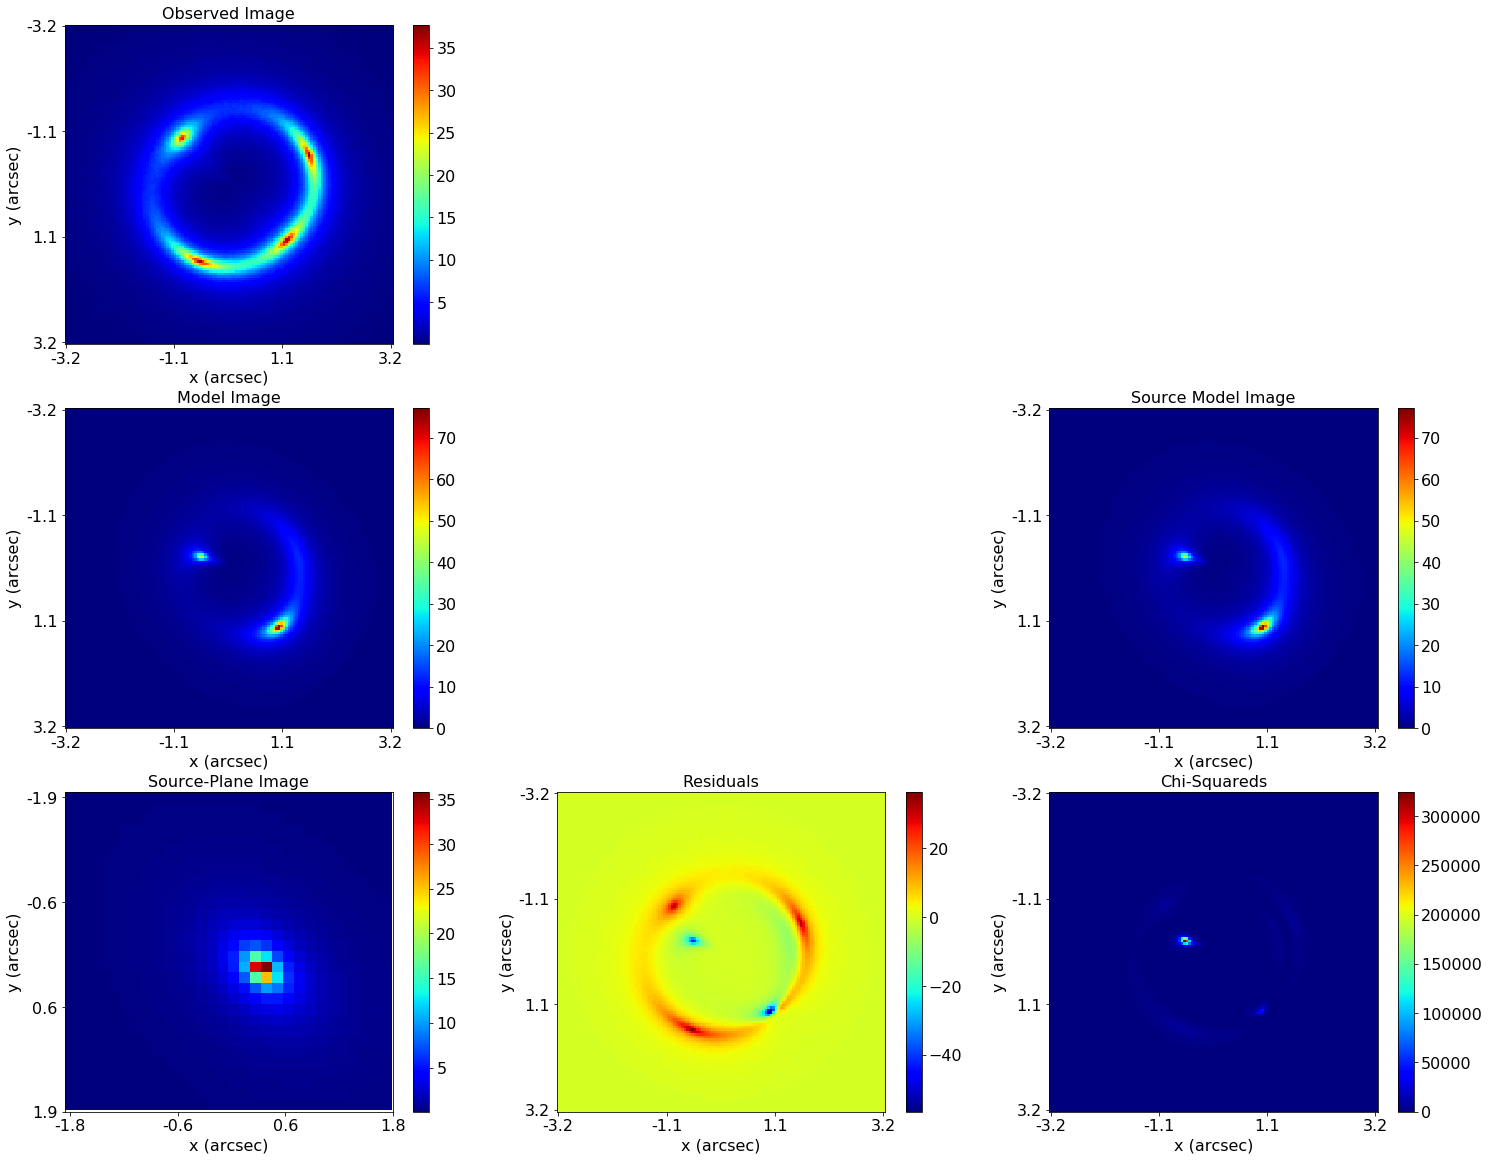

In [19]:
# Lets change the tracer, one more time, to a solution that is nowhere near the correct one.
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(-0.05, -0.05), einstein_radius=1.2, axis_ratio=0.6,
                                                    phi=80.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.2, 0.4), axis_ratio=0.7, phi=50.0,
                                                        intensity=1.2, effective_radius=0.8, sersic_index=3.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
fit = fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting(fit=fit)

In [21]:
# Clearly, the model provides a terrible fit, and this tracer is not a plausible representation of 
# the image-data  (of course, we already knew that, given that we simulated it!)

# The likelihood drops dramatically, as expected.
print('Previous Likelihoods:')
print(11697.24)
print(10319.44)
print('New Likelihood:')
print(fit.likelihood)

Previous Likelihoods:
11697.24
10319.44
New Likelihood:
-4270939.8544403445


In [ ]:
# Congratulations, you've fitted your first strong lens with PyAutoLens! Perform the following exercises:

# 1) In this example, we 'knew' the correct solution, because we simulated the lens ourselves. In the real Universe,
#    we have no idea what the correct solution is. How would you go about finding the correct solution? 
#    Could you find a solution that fits the data reasonable through trial and error?
